# Import & setup

In [102]:
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt

import csv

import psycopg2 as ps

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

import os

In [103]:
SEED = 31827

PATH_DATA = 'data'
PATH_DATA_TREATED = os.path.join(PATH_DATA, 'treated')

FILE_DATA = os.path.join(PATH_DATA, 'Obesity.csv')
FILE_DATA_TREATED_EDA = os.path.join(PATH_DATA_TREATED, 'obesity-eda.csv')
FILE_DATA_TREATED_ML = os.path.join(PATH_DATA_TREATED, 'obesity-ml.csv')


PATH_LOCAL = 'ignore'

FILE_POSTGRES_PW = os.path.join(PATH_LOCAL, 'postgres-pw')

In [104]:
# making the folders
try: 
    os.makedirs(PATH_DATA_TREATED)
except Exception as e:
    print(f'Failed to create folder | {e}')

try: 
    os.makedirs(PATH_LOCAL)
except Exception as e:
    print(f'Failed to create folder | {e}')

Failed to create folder | [WinError 183] Cannot create a file when that file already exists: 'data\\treated'
Failed to create folder | [WinError 183] Cannot create a file when that file already exists: 'ignore'


# Análise preliminar

In [105]:
df = pd.read_csv(FILE_DATA)

df_copy = df.copy()

df.head(3)

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


## Construindo Pipeline

### Tratando nomes das colunas

In [106]:
class FormatColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        df.columns = [col.lower().strip() for col in df.columns]
        return df

In [107]:
df.dtypes

Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

### Tratando os registros

In [108]:
class FormatStrings(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].str.lower()
                df[col] = df[col].str.strip()
        return df

### Colunas numéricas
#### Decimais

In [109]:
cols_decimal = [
    'height',
    'weight'
    ]

In [110]:
class ToFloat(BaseEstimator, TransformerMixin):
    def __init__(self,
                 to_float : list = cols_decimal) -> None:
        self.to_float = to_float
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        for col in self.to_float:
            df[col] = df[col].astype(float)
        return df

#### Inteiras

In [111]:
cols_int = [
    'age',
    'fcvc',
    'ncp',
    'ch2o',
    'faf',
    'tue'
]

cols_int_unformatted = [
    'Age',
    'FCVC',
    'NCP',
    'CH2O',
    'FAF',
    'TUE'
]


In [112]:
df[cols_int_unformatted].describe()

,Age,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,3.000000,4.000000,3.000000,3.000000,2.000000


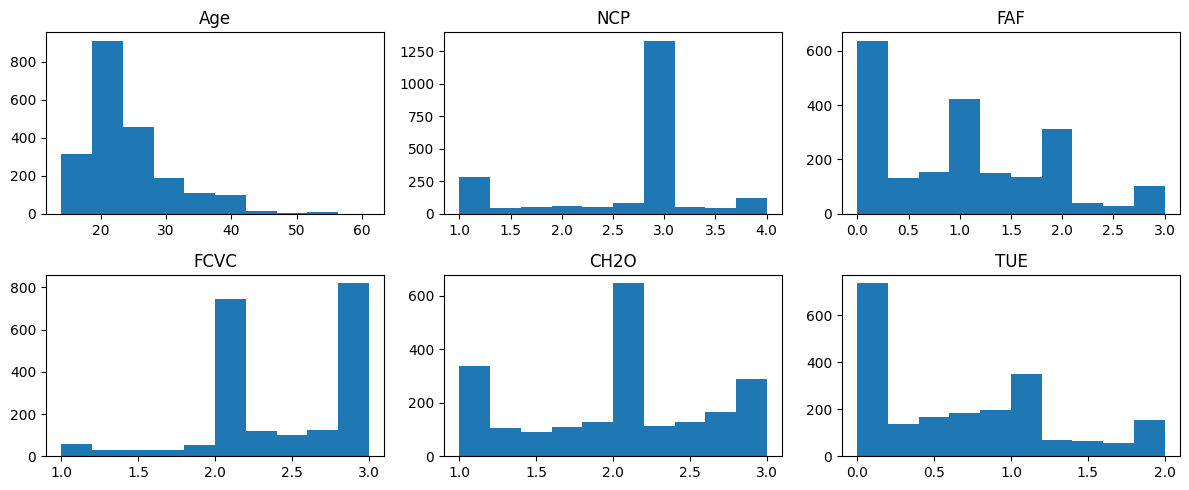

In [113]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 5))

count_row = 0
count_col = 0


for col in cols_int_unformatted:
    if count_row > nrows - 1:
        count_row = 0
        count_col += 1
    ax = axs[count_row, count_col]
    ax.hist(df[col])
    ax.set_title(col)

    count_row += 1

plt.tight_layout()

Podemos fazer um arredondamento simples.

In [114]:
class ToInt(BaseEstimator, TransformerMixin):
    def __init__(self,
                 to_float : list = cols_int) -> None:
        self.to_float = to_float
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        for col in self.to_float:
            df[col] = df[col].round().astype(int)
        return df

## Colunas categóricas

In [115]:
cols_categorical = [
    'gender', 
    'mtrans'
]

In [116]:
class OneHot(BaseEstimator, TransformerMixin):
    def __init__(self,
                 to_onehot : list = cols_categorical) -> None:
        self.to_onehot = to_onehot
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        # create encoder
        enc = OneHotEncoder()

        # fit encoder
        enc.fit(df[self.to_onehot])

        # get the names of the new columns
        features = enc.get_feature_names_out(self.to_onehot)

        # make a dataframe with the new columns
        temp_df = pd.DataFrame(
            enc.transform(df[self.to_onehot]).astype(int).toarray(),
            columns = features,
            index = df.index
            )

        # concatenating with a slice of the original dataframe
        other_features = [feat for feat in df.columns if feat not in self.to_onehot]

        df_concat = pd.concat(
            [df[other_features],
            temp_df],
            axis = 1
        )

        return df_concat

## Colunas ordinais

In [117]:
df.CAEC.unique()

array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

In [118]:
df.CALC.unique()

array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

In [119]:
cols_ordinal = {
    'caec':['no', 'sometimes', 'frequently', 'always'],
    'calc':['no', 'sometimes', 'frequently', 'always'],
    'obesity':['insufficient_weight',
                'normal_weight',
                'overweight_level_i',
                'overweight_level_ii',
                'obesity_type_i',
                'obesity_type_ii',
                'obesity_type_iii']
}

In [120]:
class ToOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self,
                 ordinal_dict : dict = cols_ordinal) -> None:
        self.ordinal_dict = ordinal_dict
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        for col in self.ordinal_dict:
            encoder = OrdinalEncoder(
                categories = [self.ordinal_dict[col]]
            )

            df[col] = encoder.fit_transform(df[[col]]).astype(int)

        return df

## Colunas binárias

In [121]:
cols_binary = [
    'family_history',
    'favc',
    'smoke',
    'scc'
]

cols_binary_unformatted = [
    ''
    'family_history',
    'FAVC',
    'SMOKE',
    'SCC'
]

dict_yn = {
    'yes': 1,
    'no': 0
}

for col in cols_binary_unformatted:
    print(df[col].unique())

['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [122]:
class ToBinary(BaseEstimator, TransformerMixin):
    def __init__(self,
                 to_binary : list = cols_binary) -> None:
        self.to_binary = to_binary
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        for col in self.to_binary:
            df[col] = df[col].map(dict_yn).astype(int)
        return df

## Coluna Target

In [123]:
class MakeObesityTarget(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass
    
    def fit(self, df, y = None):
        return self
    
    def transform(self, df):
        df['target'] = df['obesity'] > 3
        df['target'] = df['target'].astype(int)

        return df

# Pipeline Final

In [124]:
def apply_pipeline_ML(df):
    pipeline = Pipeline(steps = [
        ('format columns', FormatColumnNames()),
        ('format strings', FormatStrings()),
        ('to ordinal', ToOrdinal()),
        ('to float', ToFloat()),
        ('to int', ToInt()),
        ('to binary', ToBinary()),
        ('onehot', OneHot()),
        ('make target', MakeObesityTarget())
    ]
    )

    copy = df.copy()

    df_pipeline = pipeline.fit_transform(copy)

    return df_pipeline

def apply_pipeline_EDA(df):
    pipeline = Pipeline(steps = [
        ('format columns', FormatColumnNames()),
        ('format strings', FormatStrings()),
        ('to float', ToFloat()),
        ('to int', ToInt())
    ]
    )

    copy = df.copy()

    df_pipeline = pipeline.fit_transform(copy)

    return df_pipeline


df_ML = apply_pipeline_ML(df)

df_EDA = apply_pipeline_EDA(df)

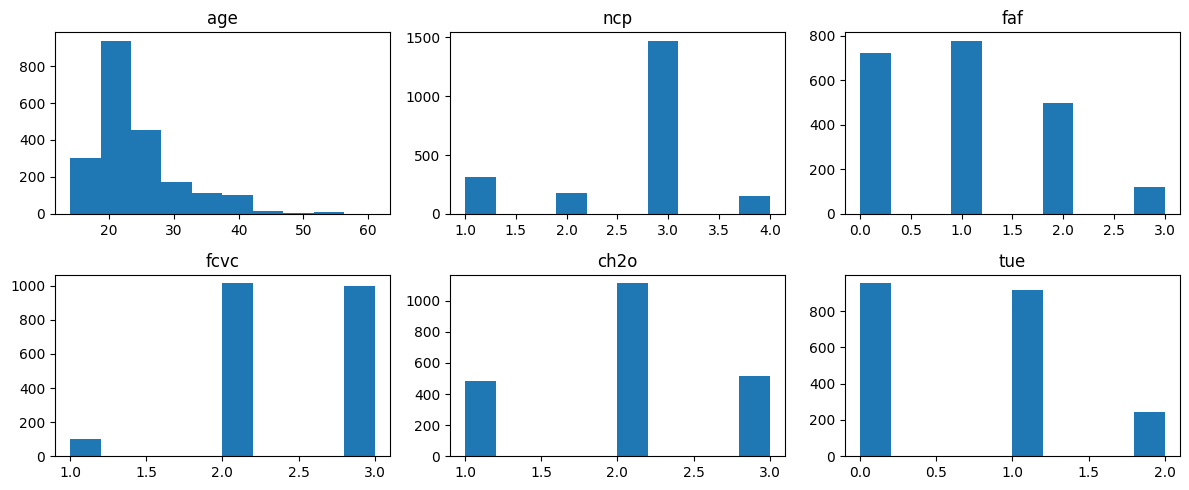

In [125]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12, 5))

count_row = 0
count_col = 0


for col in cols_int:
    if count_row > nrows - 1:
        count_row = 0
        count_col += 1
    ax = axs[count_row, count_col]
    ax.hist(df_ML[col])
    ax.set_title(col)

    count_row += 1

plt.tight_layout()

## Dicionário das colunas
- Age — (Idade) Idade em anos. Valores: numérico contínuo (mín 14, máx 61).
- Height — (Altura) Altura em metros. Valores: numérico contínuo (ex.: 1.45–1.98 m).
- Weight — (Peso) Peso em quilogramas. Valores: numérico contínuo (ex.: 39–173 kg).
- family_history — (Family history of overweight) Histórico familiar de excesso de peso. Valores: yes (há histórico), no (não há).
- FAVC — (Frequent consumption of high-caloric food) Consumo frequente de alimentos muito calóricos. Valores: yes (sim), no (não).
- FCVC — (Frequency of consumption of vegetables) Frequência de consumo de vegetais nas refeições. Valores (escala 1–3): 1 raramente, 2 às vezes, 3
sempre. Nota: no arquivo os valores aparecem com decimais (ruído); interprete arredondando para o inteiro mais próximo.
- NCP — (Number of main meals) Número de refeições principais por dia. Valores (escala 1–4): 1 uma refeição, 2 duas, 3 três, 4 quatro ou mais. Nota: valores com decimais devem ser arredondados.
- CAEC — (Consumption of food between meals) Consumo de lanches/comes entre as refeições. Valores: no (não consome), Sometimes (às vezes), Frequently (frequentemente), Always (sempre).
- SMOKE — (Smoking) Hábito de fumar. Valores: yes (fuma), no (não fuma).
- CH2O — (Daily water consumption) Consumo diário de água. Valores (escala 1–3): 1 < 1 L/dia, 2 1–2 L/dia, 3 > 2 L/dia. Nota: arredonde valores decimais para interpretar a categoria.
- SCC — (Calories consumption monitoring) Monitora a ingestão calórica diária. Valores: yes (sim), no (não).
- FAF — (Physical activity frequency) Frequência semanal de atividade física. Valores (escala 0–3): 0 nenhuma, 1 ~1–2×/sem, 2 ~3–4×/sem, 3 5×/sem ou mais. Nota: arredonde valores decimais.
- TUE — (Time using electronic devices) Tempo diário usando dispositivos eletrônicos. Valores (escala 0–2): 0 ~0–2 h/dia, 1 ~3–5 h/dia, 2 > 5 h/dia.Nota: arredonde valores decimais.
- CALC — (Alcohol consumption) Consumo de bebida alcoólica. Valores: no (não bebe), Sometimes (às vezes), Frequently (frequentemente), Always
(sempre).
- MTRANS — (Transportation used / Mode of transport) Meio de transporte habitual. Valores: Automobile (carro), Motorbike (moto), Bike (bicicleta),
- Public_Transportation (transporte público), Walking (a pé).
- Obesity — (Target label / Nível de obesidade) Classe de peso corporal. Valores: Insufficient_Weight (abaixo do peso), Normal_Weight (peso normal),Overweight_Level_I (sobrepeso I), Overweight_Level_II (sobrepeso II), Obesity_Type_I (obesidade I), Obesity_Type_II (obesidade II),
Obesity_Type_III (obesidade III).

# Conexão com o PostgreSQL

In [126]:
def connect_to_db(
        dbname = 'TC4',
        user = 'postgres',
        password_path = FILE_POSTGRES_PW,
        host = 'localhost',
        port = '5432'
):
    password = ''
    with open(password_path) as f:
        password = f.read()

    conn = ps.connect(
        dbname = dbname,
        user = user,
        password = password,
        host = host,
        port = port
    )

    return conn

In [127]:
try:
    conn = connect_to_db()
    sql_create_schema = 'CREATE SCHEMA IF NOT EXISTS tc4;'
    
    cursor = conn.cursor()

    # 4. Execute the CREATE TABLE statement
    cursor.execute(sql_create_schema)

    # 5. Commit the transaction
    conn.commit()
    print("Schema created successfully!")
except Exception as e:
    print(f'Failed to create schema | {e}')
    conn.rollback()
finally:
    # 6. Close the cursor and connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Schema created successfully!


In [128]:
cols_ordinal

{'caec': ['no', 'sometimes', 'frequently', 'always'],
 'calc': ['no', 'sometimes', 'frequently', 'always'],
 'obesity': ['insufficient_weight',
  'normal_weight',
  'overweight_level_i',
  'overweight_level_ii',
  'obesity_type_i',
  'obesity_type_ii',
  'obesity_type_iii']}

In [129]:
sql_create_table = '''
DROP TABLE IF EXISTS tc4.obesity;
CREATE TABLE IF NOT EXISTS tc4.obesity(
    gender VARCHAR(25),
    age INT,
    height FLOAT,
    weight FLOAT,
    family_history VARCHAR(255),
    favc VARCHAR(255),
    fcvc INT,
    ncp INT,
    caec VARCHAR(255),
    smoke VARCHAR(255),
    ch2o INT,
    scc VARCHAR(255),
    faf INT,
    tue INT,
    calc VARCHAR(255),
    mtrans VARCHAR(255),
    obesity VARCHAR(255)
)
'''

In [130]:
try:
    conn = connect_to_db()
    cursor = conn.cursor()

    # 4. Execute the CREATE TABLE statement
    cursor.execute(sql_create_table)

    # 5. Commit the transaction
    conn.commit()
    print("Table created successfully!")
except Exception as e:
    print(f'Failed to create schema | {e}')
    conn.rollback()
finally:
    # 6. Close the cursor and connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Table created successfully!


## Subindo nossos dados

In [131]:
df_EDA.to_csv(FILE_DATA_TREATED_EDA, index = False)
df_ML.to_csv(FILE_DATA_TREATED_ML, index = False)

In [132]:
def ingest_data(file, table = 'tc4.obesity'):
    conn = connect_to_db()
    cursor = conn.cursor()
    try:
        with open(file, 'r') as file:
            # reader = csv.reader(file)
            next(file) # skips header
            cursor.copy_expert(f'COPY {table} FROM STDIN WITH (FORMAT CSV)', file)
    except Exception as e:
        conn.rollback()
        print(f'Failed to insert | {e}')
    finally:
        conn.commit()
        if cursor:
            cursor.close()
        if conn:
            conn.close()

In [133]:
ingest_data(FILE_DATA_TREATED_EDA)